# Price Simulation

We have a few ways for generating prices.

### Collateral Prices

We simulate collateral prices (e.g. WETH) as correlated GBMs. We estimate the generative GBM parameters using historical data from Coingecko (see `scripts/gen_price_config.py`).

### Stablecoin Prices

We simulate stablecoin prices (e.g. USDC) as correlated Ornstein-Uhlenbeck (OU) processes. These are simply mean-reverting GBMs. We similarly estimate the generative OU parameters using a Maximum Likelihood Estimator (MLE) on historical Coingecko data (see `src/prices/utils.py`).

## Shocks

We apply three kinds of shocks in different scenarios:

1. Drift-shock: we may shock the drift parameter of the collateral GBMs. This allows us to control the expected returns per-timestep. For example, the baseline scenarios will shock the drift by setting it to 0. See `src/sim/scenarios/baseline/__init__.py`.
2. Volatility-shock: we may shock the volatility parameter of the collateral or stablecoin processes. This allows us to enforce higher price volatility in our simulations.
3. Jumps.

We will dive deeper into jumps in this notebook.

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from src.sim.scenario import Scenario
from src.prices.utils import get_factor, gen_cor_prices, get_gran
from datetime import datetime
import pandas as pd
import requests as req
from src.plotting.utils import make_square
from src.plotting import plot_prices
from src.configs import get_price_config
from src.configs.tokens import WETH, WSTETH, SFRXETH, WBTC, TBTC, USDC

plt.rcParams["axes.spines.right"] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimating Stressed Drift and Volatility

Our stress scenarios consider stressed drift and volatility parameters for simulating collateral prices. We calculate the stress variables as follows:

### Stressed Volatility

We take the p99 standard deviation of log returns. 

More specifically, we fetch hourly price data from Jan20 to Jan24. We resample this data at the simulation frequency (5min). We then compute the log returns of our data. From these 5min log returns, we compute the intraday volatility for the asset as the standard deviation of log returns in a 1 day rolling window.

We assume that wstETH and sfrxETH have similar stressed volatilities to ETH (we have much more data on ETH price volatility!)

In [11]:
# Fetch prices from cryptocompare (more granular than CoinGecko)
url = "https://min-api.cryptocompare.com/data/v2/histohour"
params = {
    "tsym": "USD",
    "limit": 2000,
}


def fetch(sym, end=None):
    if end:
        params["toTs"] = end
    params["fsym"] = sym
    res = req.get(url, params=params)
    data = res.json()["Data"]
    start = data["TimeFrom"]
    df = pd.DataFrame(data["Data"])
    df.set_index(pd.to_datetime(df["time"], unit="s"), inplace=True)
    df = df["close"]
    return df, start


def fetch_all(sym, start, freq):
    dfs = []
    ts = datetime.now().timestamp()
    while ts > start:
        df, ts = fetch(sym, ts)
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_index(inplace=True)
    df = df.resample(freq).last().ffill()
    return pd.DataFrame(df)


def get_rolling_std(df, freq, window):
    annual_factor = get_factor(freq)
    col = "close"
    df[f"{col}_returns"] = df[col].pct_change()
    df[f"{col}_log_returns"] = np.log1p(df[f"{col}_returns"])
    rolling_std = df[f"{col}_log_returns"].rolling(window).std() * np.sqrt(
        annual_factor
    )
    rolling_mu = df[f"{col}_log_returns"].rolling(window).mean() * annual_factor
    return rolling_std, rolling_mu


def calc_stressed_volatilites(syms, start, freq, window, plot=False):
    """
    Calculate the stressed volatilities for the input coins.
    Optionally plot.
    """
    stats = []

    if plot:
        n, m = make_square(len(syms) * 2)
        f, axs = plt.subplots(n, m, figsize=(15, 15))
        flat = axs.flatten()

    for i, sym in enumerate(syms):
        # Fetch and process data
        df = fetch_all(sym, start, freq)
        rolling_std, rolling_mu = get_rolling_std(df, freq, window)
        stats.append(
            {
                "symbol": sym,
                "vol_mean": rolling_std.mean(),
                "vol_std": rolling_std.std(),
                "vol_median": rolling_std.quantile(0.5),
                "vol_p95": rolling_std.quantile(0.95),
                "vol_p99": rolling_std.quantile(0.99),
                "mu_mean": rolling_mu.mean(),
                "mu_std": rolling_mu.std(),
                "mu_median": rolling_mu.quantile(0.5),
                "mu_p05": rolling_mu.quantile(0.05),
                "mu_p01": rolling_mu.quantile(0.01),
            }
        )

        if plot:
            ax1 = flat[i]
            ax2 = flat[i + len(syms)]

            ax1.hist(rolling_std, bins=50, color="indianred")
            ax1.set_xlabel("Volatility")
            ax1.set_title(f"{sym} Intraday Volatility Histogram")

            ax2.hist(rolling_mu, bins=50, color="indianred")
            ax2.set_xlabel("Mu")
            ax2.set_title(f"{sym} Intraday Mu Histogram")

    if plot:
        f.tight_layout()
        plt.show()

    stats = pd.DataFrame(stats)
    stats.set_index("symbol", inplace=True)
    return stats

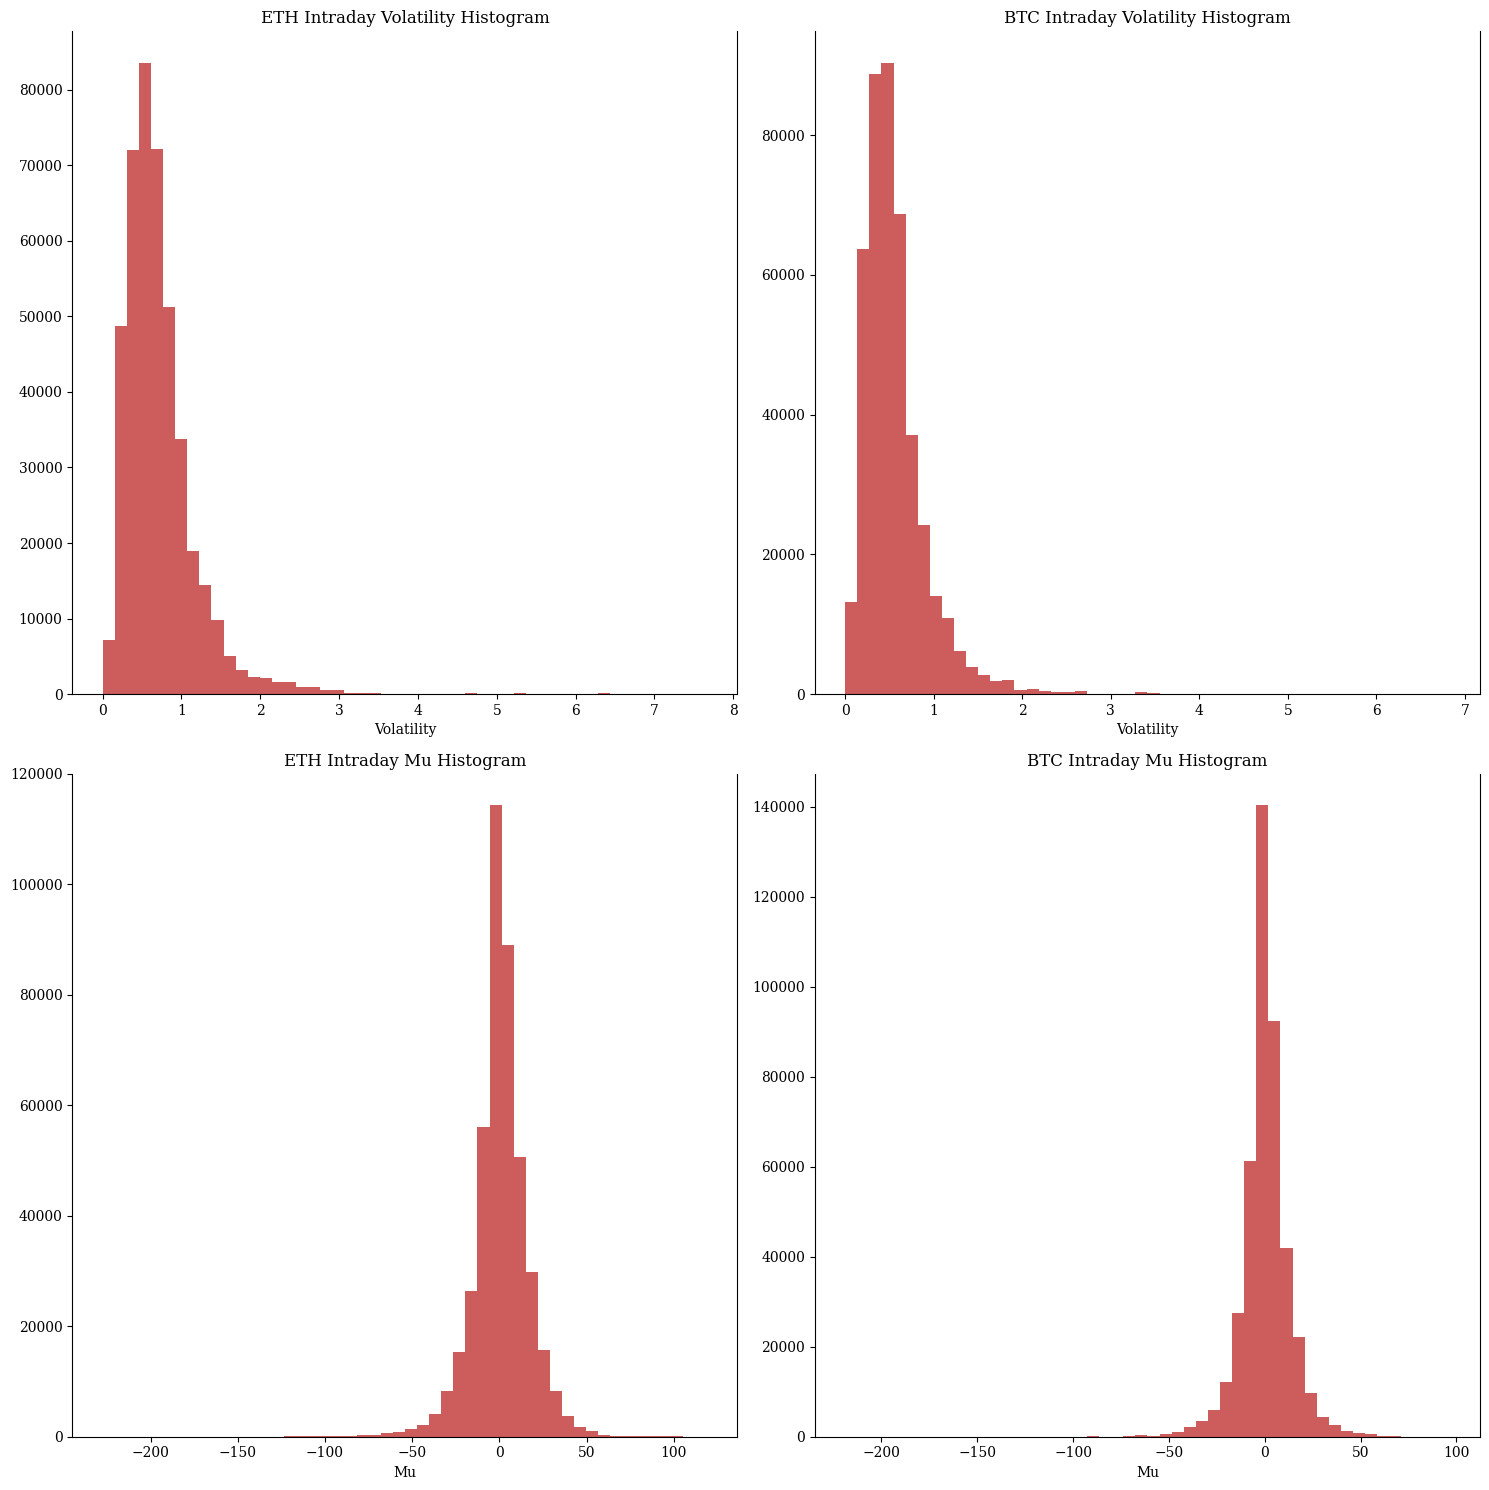

,vol_mean,vol_std,vol_median,vol_p95,vol_p99,mu_mean,mu_std,mu_median,mu_p05,mu_p01
symbol,,,,,,,,,,
ETH,0.717733,0.479628,0.620905,1.507219,2.445831,0.683333,16.215782,0.528827,-24.68442,-47.030258
BTC,0.560538,0.392677,0.484480,1.211855,1.877968,0.421511,12.781820,0.341322,-19.10171,-37.011385


In [26]:
freq = "5min"
window = "1d"
start = int(datetime(2020, 1, 1).timestamp())
stats = calc_stressed_volatilites(["ETH", "BTC"], start, freq, window, plot=True)
stats

## Plotting the difference in prices

Does scaling volatility lead to meaningfully different prices?

In [38]:
markets = ["wsteth", "weth", "wbtc", "sfrxeth"]

baseline = Scenario("baseline", markets)
highvol = Scenario("high_volatility", markets)

[INFO][12:00:11][src.sim.scenario]-13322: Fetching wsteth market from subgraph
[WARNING][12:00:13][crvusdsim.pool_data.metadata.market]-13322: User 0x76f7af8bea6462b17367eabd3fef08238d815f84 has shares in band 222 but band is empty. Skipping user...
[INFO][12:00:14][src.sim.scenario]-13322: Market snapshot as 2024-01-15 10:02:35
[INFO][12:00:14][src.sim.scenario]-13322: Bands snapshot as 2024-01-14 19:02:47
[INFO][12:00:14][src.sim.scenario]-13322: Users snapshot as 2024-01-15 11:10:35
[INFO][12:00:14][src.sim.scenario]-13322: Fetching weth market from subgraph
[INFO][12:00:17][src.sim.scenario]-13322: Market snapshot as 2024-01-15 10:02:35
[INFO][12:00:17][src.sim.scenario]-13322: Bands snapshot as 2024-01-14 19:02:47
[INFO][12:00:17][src.sim.scenario]-13322: Users snapshot as 2024-01-15 11:10:35
[INFO][12:00:17][src.sim.scenario]-13322: Fetching wbtc market from subgraph
[INFO][12:00:20][src.sim.scenario]-13322: Market snapshot as 2024-01-15 10:02:35
[INFO][12:00:20][src.sim.scenario

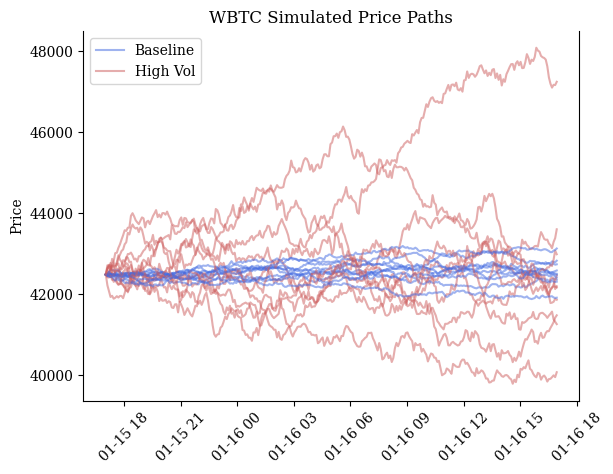

In [40]:
f, ax = plt.subplots()

for i in range(10):
    baseline.generate_pricepaths()
    highvol.generate_pricepaths()
    baseline_label = highvol_label = None
    if i == 0:
        baseline_label = "Baseline"
        highvol_label = "High Vol"
    ax.plot(
        baseline.pricepaths.prices[WBTC],
        color="royalblue",
        alpha=0.5,
        label=baseline_label,
    )
    ax.plot(
        highvol.pricepaths.prices[WBTC],
        color="indianred",
        alpha=0.5,
        label=highvol_label,
    )

ax.legend()
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel("Price")
ax.set_title("WBTC Simulated Price Paths")
print()

# Simple Correlated Merton Jump-Diffusion Process

We tried to enhance our correlated GBM process with stochastic "jumps". These jumps are modeled as a Poisson process (to sample whether they happen at a given timestep). We model 1 Poisson process for the entire collateral market, meaning that if one asset experiences a jump (e.g. ETH), then other assets will also experience a jump. This follows from the fact that many assets being simulated are derivatives of other assets (e.g. wstETH and WETH), and from the fact that BTC and ETH are very correlated.

### Flash Crashes

We find that stochastic jumps do not meaningfully influence the results in our risk model since they occur very infrequently (i.e. a very small percentage of simulations will experience a jump over the course of a day). 

This is because of a fundamental tradeoff when fitting jump processes. To determine the intensity and size of a jump, we need data on previous jumps. This means we need to classify price movements as jumps or not jumps, which we do by setting a (somewhat arbitrary) threshold. We first take the mean and standard deviation of log returns from historical price data. We then assign an arbitrary number of standard deviations as our threshold for a jump, e.g. 10 standard deviations from the mean log return is a jump. If we set this number too high, then we will get very large and infrequent jumps. If we set the number too low, then we'll get very frequent but immaterial jumps. This is due to the intrinsically volatile nature of crypto assets: they have very fat tails.

Intuitively, jumps are a meaningful risk vector we must explore. We "zoom into" the risk presented by jumps by creating a set of stress scenarios that enforce exactly one downward jump in market prices at the half-way point in the simulation. For a 24 hour simulation horizon, this means that at the 12 hour mark all simulations will experience a jump of varying intensities. Before and after the jump, the prices for all simulations behave as correlated GBMs.

We sample the jump intensity from a multivariate log-normal distribution. This allows us to enforce a correlation between the jump intensities of each market.

We enforce that the jump be negative.

In [5]:
num_steps = 288
freq = "5min"
config = get_price_config(freq, 1697068800, 1704585600)
coin_ids = list(config["params"].keys())
annual_factor = get_factor(freq)
dt = 1 / annual_factor
T = num_steps * dt

In [81]:
def calc_jump_params(sym, data, num_stds=20, plot=False):
    """
    Compute mu_j and sigma_j from given price data.

    Methodology: threshold detection.

    Note
    ----
    Not annualized!
    """
    data = data.copy()
    data["returns"] = data["close"].pct_change()
    data["log_returns"] = np.log1p(data["returns"])
    data = data.dropna()

    std = data["log_returns"].std()
    threshold = data["log_returns"].mean() + num_stds * std

    data.loc[:, "is_jump"] = (
        data["log_returns"].copy() < -threshold
    )  # NOTE only considering negative jumps

    if plot:
        f, ax = plt.subplots()
        ax.plot(data["close"], color="royalblue", lw=2)
        for i, row in data.iterrows():
            if row["is_jump"]:
                ax.axvline(i, color="indianred", linestyle="--", lw=1)
        ax.tick_params(axis="x", rotation=45)
        ax.set_ylabel("Price")
        ax.set_title(f"Detecting {sym} Price Jumps")
        plt.show()

    mu_j = data[data["is_jump"]]["log_returns"].mean()
    sigma_j = data[data["is_jump"]]["log_returns"].std()

    return mu_j, sigma_j


def calc_flash_crash_params(syms, start, freq, num_stds=20, plot=False):
    """
    Calculate the flash crash parameters for the input coins.
    """
    stats = []
    for i, sym in enumerate(syms):
        # Fetch and process data
        df = fetch_all(sym, start, freq)
        mu_j, sigma_j = calc_jump_params(sym, df, num_stds=num_stds, plot=plot)
        stats.append(
            {
                "symbol": sym,
                "mu_j": round(mu_j, 6),
                "sigma_j": round(sigma_j, 6),
            }
        )
    stats = pd.DataFrame(stats)
    stats.set_index("symbol", inplace=True)
    return stats


def make_flash_crash_params(mu_j_eth, sigma_j_eth, mu_j_btc, sigma_j_btc):
    """
    Make the flash crash params for the given coins.
    """
    # Flash crash config
    coins_j = [WETH, WSTETH, SFRXETH, WBTC, TBTC]

    mu_j = [mu_j_eth, mu_j_eth, mu_j_eth, mu_j_btc, mu_j_btc]
    std_j = [sigma_j_eth, sigma_j_eth, sigma_j_eth, sigma_j_btc, sigma_j_btc]

    # Assume full correlation during jumps
    n = len(coins_j)
    corr_j = np.ones((n, n))

    cov_j = np.outer(std_j, std_j) * corr_j

    return {"type": "flash_crash", "coins_j": coins_j, "mu_j": mu_j, "cov_j": cov_j}

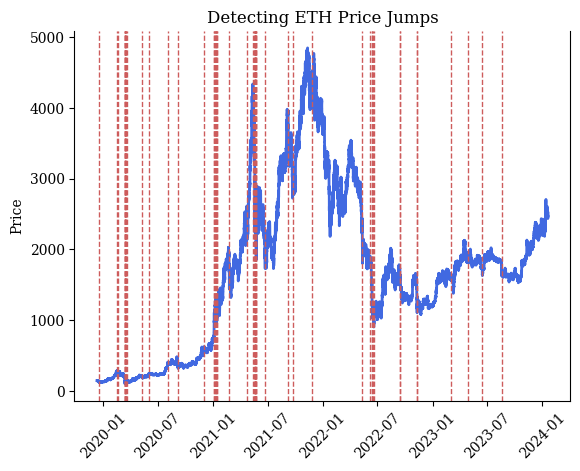

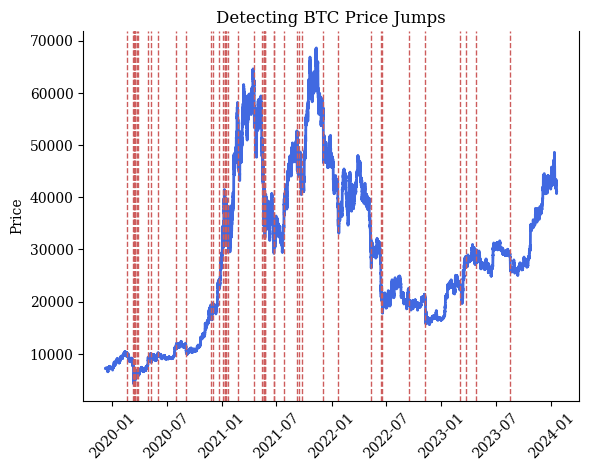

,mu_j,sigma_j
symbol,,
ETH,-0.074193,0.030926
BTC,-0.061255,0.026896


In [34]:
start = int(datetime(2020, 1, 1).timestamp())
freq = "5min"
jump_stats = calc_flash_crash_params(["ETH", "BTC"], start, freq, plot=True)
jump_stats

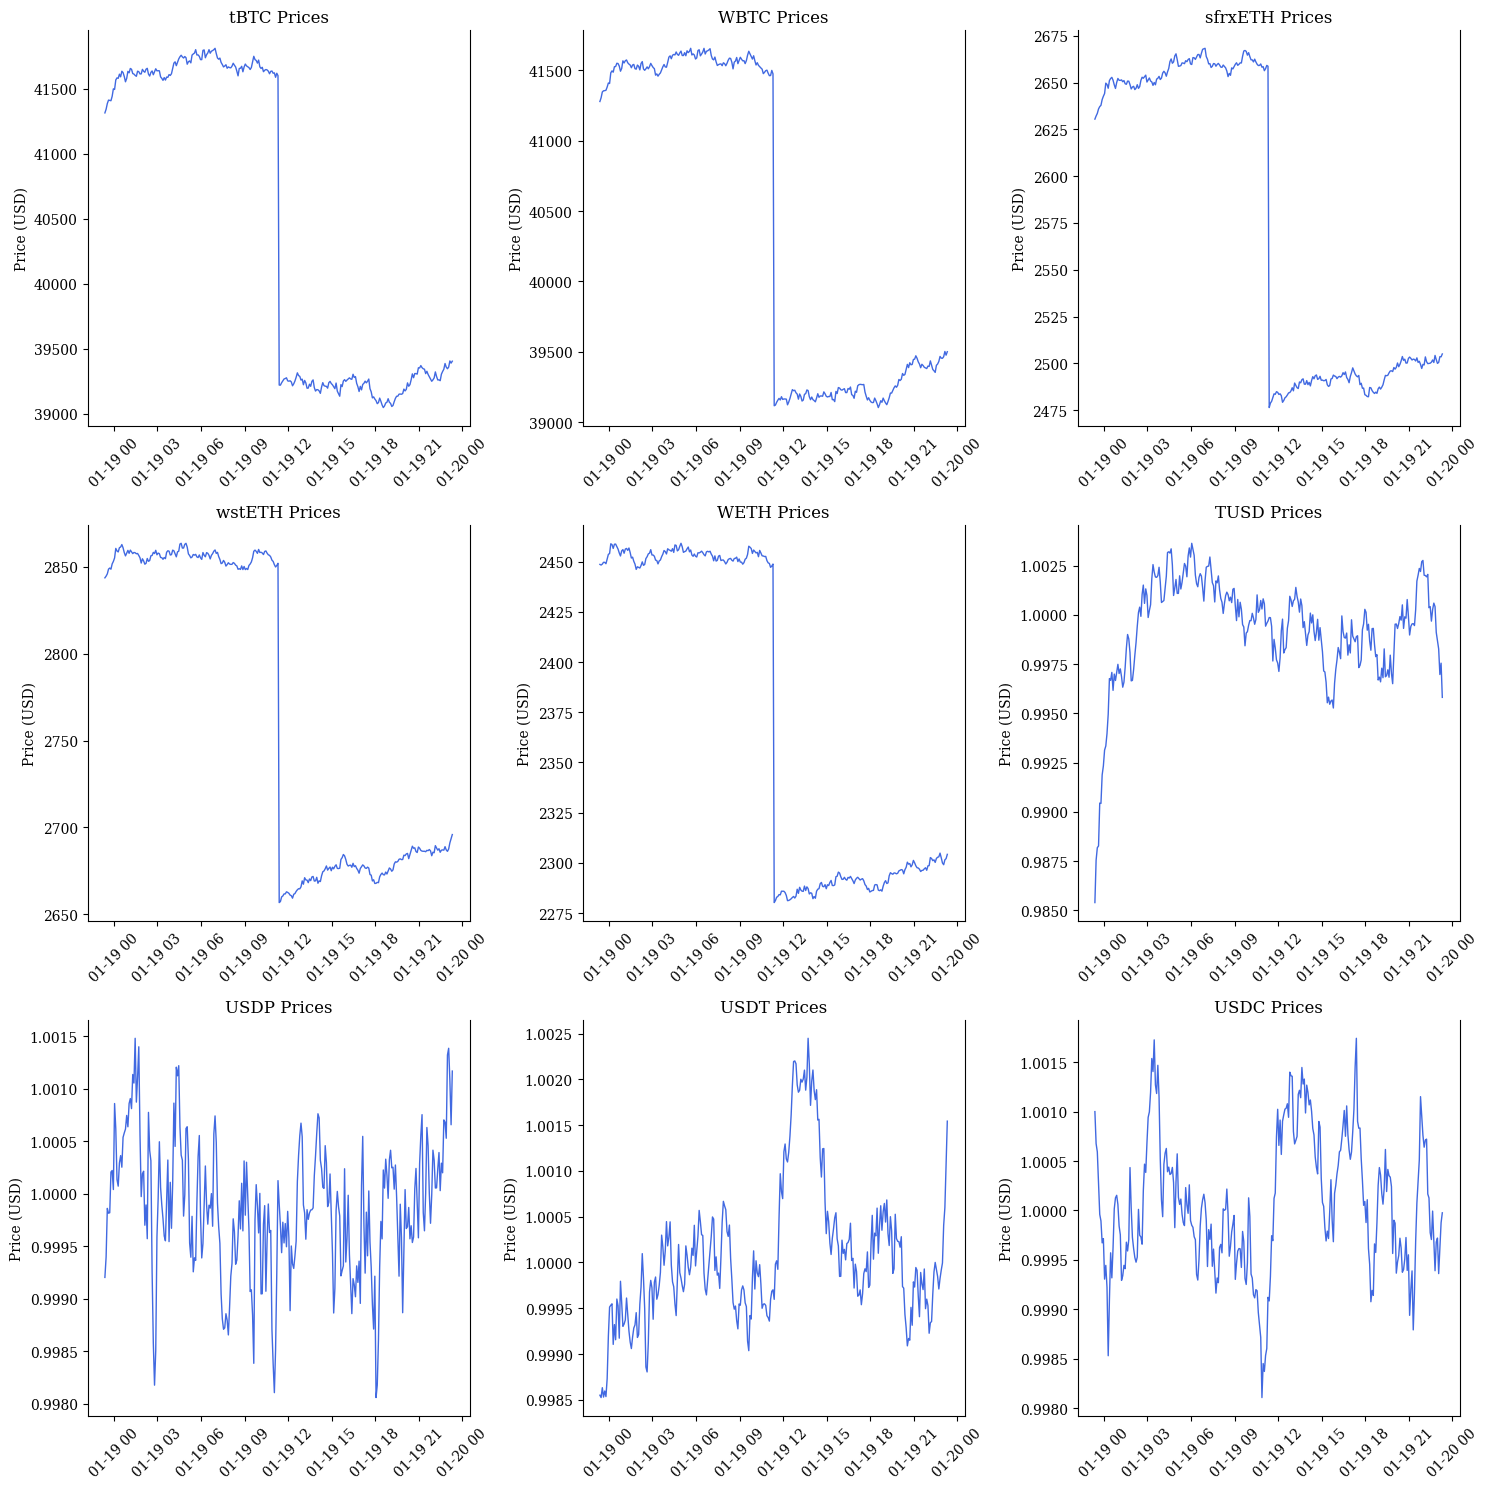

In [35]:
mu_j_eth, sigma_j_eth = jump_stats.loc["ETH"].to_list()
mu_j_btc, sigma_j_btc = jump_stats.loc["BTC"].to_list()
jump_params = make_flash_crash_params(mu_j_eth, sigma_j_eth, mu_j_btc, sigma_j_btc)
prices = gen_cor_prices(
    coin_ids,  # List of coin IDs (coingecko)
    T,  # Time horizon in years
    dt,  # Time step in years
    config["curr_prices"],
    pd.DataFrame.from_dict(config["cov"]),
    config["params"],
    timestamps=True,
    gran=get_gran(freq),
    jump_params=jump_params,
)
_ = plot_prices(prices)

# Distribution of returns

We have a very fat tailed distribution of hourly log returns.

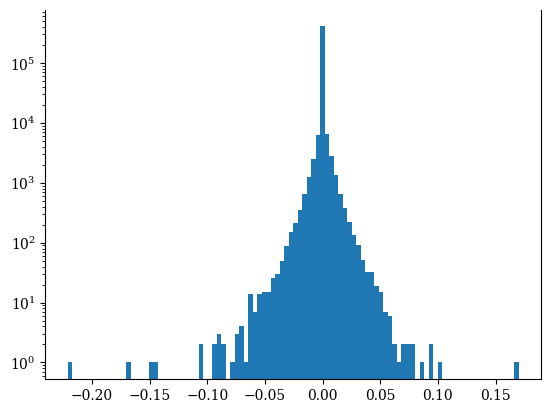

In [36]:
sym = "ETH"
df = fetch_all(sym, start, freq)
df["returns"] = df["close"].pct_change()
df["log_returns"] = np.log1p(df["returns"])
df = df.dropna()

f, ax = plt.subplots()
df["log_returns"].hist(bins=100, grid=False, ax=ax)
ax.set_yscale("log")

In [59]:
start = int(datetime(2020, 1, 1).timestamp())
freq = "5min"
jump_stats = calc_flash_crash_params(
    ["ETH", "BTC"], start, freq, num_stds=10, plot=False
)
mu_j_eth, sigma_j_eth = jump_stats.loc["ETH"].to_list()
mu_j_btc, sigma_j_btc = jump_stats.loc["BTC"].to_list()
jump_params = make_flash_crash_params(mu_j_eth, sigma_j_eth, mu_j_btc, sigma_j_btc)
jump_params

{'type': 'flash_crash',
 'coins_j': ['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
  '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0',
  '0xac3e018457b222d93114458476f3e3416abbe38f',
  '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
  '0x18084fba666a33d37592fa2633fd49a74dd93a88'],
 'mu_j': [-0.022666453625256083,
  -0.022666453625256083,
  -0.022666453625256083,
  -0.018657758200476337,
  -0.018657758200476337],
 'cov_j': array([[0.00017597, 0.00017597, 0.00017597, 0.00014909, 0.00014909],
        [0.00017597, 0.00017597, 0.00017597, 0.00014909, 0.00014909],
        [0.00017597, 0.00017597, 0.00017597, 0.00014909, 0.00014909],
        [0.00014909, 0.00014909, 0.00014909, 0.00012631, 0.00012631],
        [0.00014909, 0.00014909, 0.00014909, 0.00012631, 0.00012631]])}

# Depegs

For the flash crash scenario we simulate a market crash where all collateral prices experience a jump at a pre-determined time. Similarly, the Depeg scenario encodes that exactly one stablecoin (we chose USDC) will experience a depeg while other stablecoins remain unaffected.

Again, we have skirted the "intensity" problem of jumps by simply encoding a scenario where they occur once with a probability of 1. We must still size the intensity of the jump. Given these are stablecoins, this is much easier to do.


### Limitations

1. We do not model the reflexivity between stablecoins. When USDC depegs, it is likely that USDT will experience an opposite depeg upwards as traders rush to sell USDC for USDT. We assume USDT will continue to behave as an OU process and therefore will not necessarily spike up in price following the USDC depeg.
2. We do not assume other stablecoins (TUSD and USDP) will depeg with USDC.

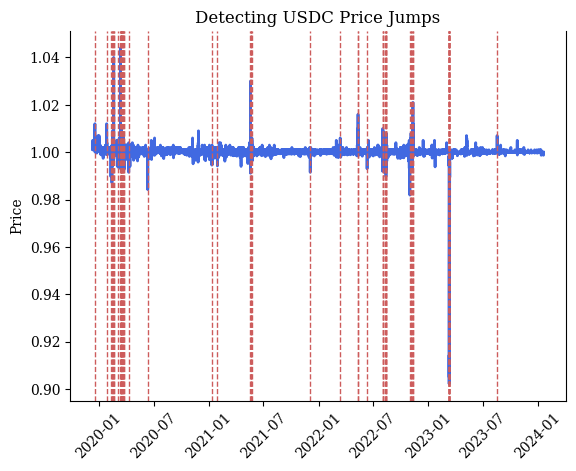

,mu_j,sigma_j
symbol,,
USDC,-0.011887,0.009651


In [85]:
start = int(datetime(2020, 1, 1).timestamp())
freq = "5min"
jump_stats = calc_flash_crash_params(["USDC"], start, freq, num_stds=20, plot=True)
jump_stats

In [95]:
def make_depeg_params(mu_j, sigma_j):
    return {
        "type": "depeg",
        "coins_j": [USDC],
        "size": -0.2,
    }


jump_params = make_depeg_params(*jump_stats.iloc[0].to_list())

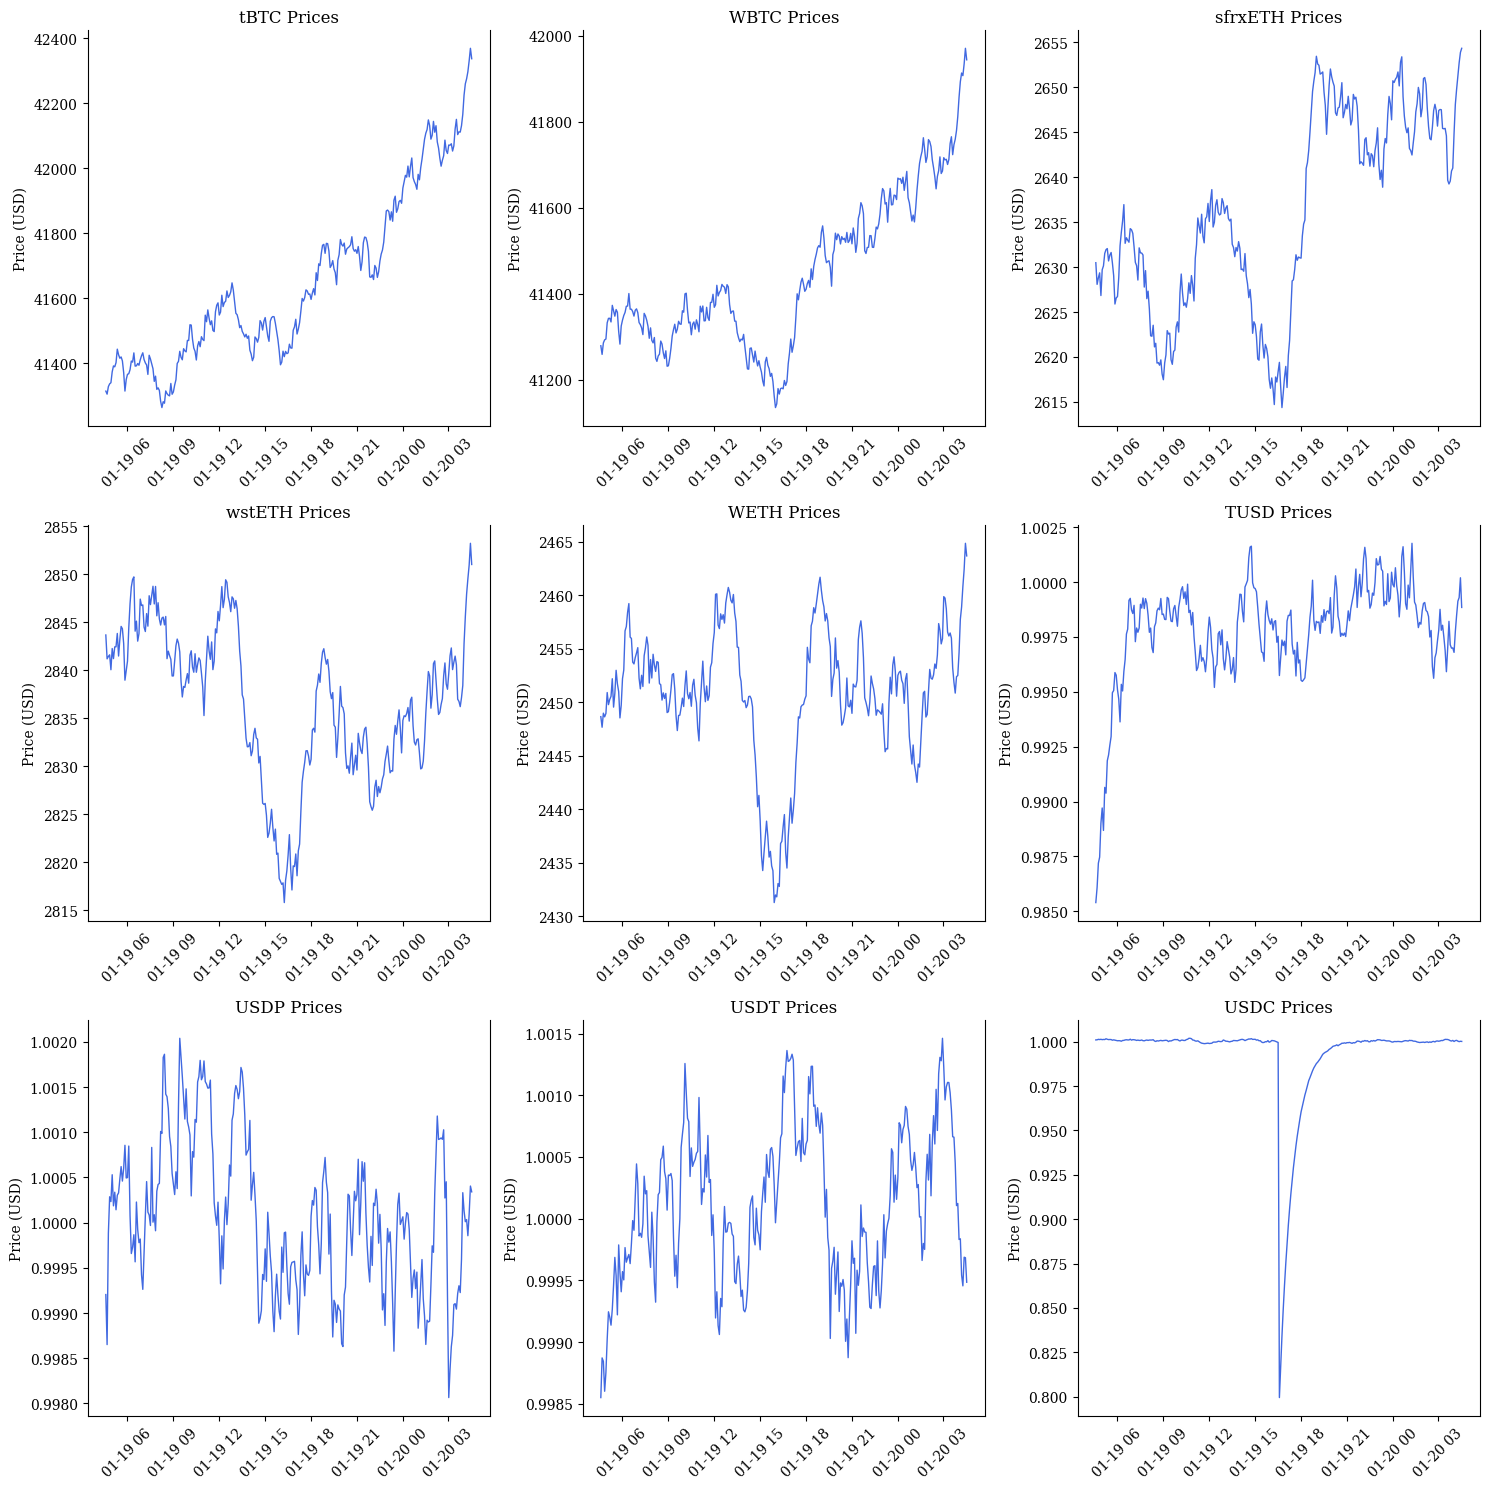

In [97]:
prices = gen_cor_prices(
    coin_ids,  # List of coin IDs (coingecko)
    T,  # Time horizon in years
    dt,  # Time step in years
    config["curr_prices"],
    pd.DataFrame.from_dict(config["cov"]),
    config["params"],
    timestamps=True,
    gran=get_gran(freq),
    jump_params=jump_params,
)
_ = plot_prices(prices)

In [98]:
from src.configs.scenarios import SCENARIOS

In [102]:
[s for s in SCENARIOS]

['baseline',
 'adverse vol',
 'severe vol',
 'adverse drift',
 'severe drift',
 'adverse growth',
 'severe growth',
 'adverse crvusd liquidity',
 'severe crvusd liquidity',
 'adverse flash crash',
 'severe flash crash',
 'adverse depeg',
 'severe depeg',
 'severe vol and adverse drift',
 'severe vol and severe drift',
 'severe vol and adverse growth',
 'severe vol and severe growth',
 'severe vol and adverse crvusd liquidity',
 'severe vol and severe crvusd liquidity',
 'adverse flash crash and adverse growth',
 'adverse flash crash and severe growth',
 'adverse flash crash and adverse crvusd liquidity',
 'adverse flash crash and severe crvusd liquidity']